In [ ]:
from IPython.display import Markdown, display
from datetime import datetime

def signature():
    display(Markdown(f"""
---
### 👨‍💻 *Authored by [Erwin R. Pasia](mailto:erwinpasia@gmail.com)*
📅 Date: {datetime.now().strftime("%B %d, %Y")}

> *"Code is poetry. Simplicity is elegance."*  
---
"""))

signature()

## Capstone Project Title: "CafeGenius" Re-Architected with LangGraph


### About: 
-  The notebook presents "CafeGenius," a conversational AI assistant designed for a cafe environment. Its primary functions are to help customers explore the menu, get personalized recommendations, inquire about specific items, build an order incrementally across multiple conversation turns, modify that order (add, remove, clear), confirm the final order, and simulate placing it.

- The use case is highly relatable and addresses a common interaction scenario. The ability to handle multi-turn conversations, maintain order state, and ground responses in actual menu data (via RAG) makes it significantly more useful than a basic FAQ bot.

- While cafe ordering bots aren't entirely new, the approach taken here demonstrates innovation. Specifically, the deliberate re-architecture from a simpler script (implied context) to a stateful agent using LangGraph showcases a modern, robust way to build such applications. The tight integration of RAG (Gemini Embeddings + ChromaDB) for accurate information retrieval and Gemini Function Calling for structured actions within the LangGraph framework is a sophisticated implementation.

- Within the context of the Capstone Project, it's impactful as it demonstrates a practical application of multiple key GenAI concepts (LLMs, RAG, Function Calling, Agentic Frameworks) to solve a tangible problem. It serves as an excellent learning example for building reliable, stateful conversational AI.



### Section 1 (Setup and Installation):
- This section ensures the necessary software foundation is in place by installing all required Python libraries using %pip install. It covers core dependencies like LangGraph, LangChain components (langchain-google-genai, langchain-core), the vector database (chromadb), Google API clients, and utilities for handling secrets (kaggle, python-dotenv) and running within a Jupyter environment (ipython, ipykernel), concluding with a crucial reminder to restart the kernel.

In [1]:
### 1. Setup and Installation
#
# Install necessary packages, including LangGraph, LangChain components, ChromaDB, and Google Generative AI.

# Remove potentially conflicting packages (optional, adjust if needed)
# %pip uninstall -qqy kfp jupyterlab

# Install required packages
# Using versions known to be relatively stable at the time of writing (example)
%pip install --upgrade --quiet "langgraph>=0.0.50" "langchain-google-genai>=1.0.3" "langchain-core>=0.1.40" "chromadb>=0.5.0" "google-api-python-client" "google-auth" "kaggle" "ipython" "ipykernel" "typing_extensions" "python-dotenv"

print("Package installation/update complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 87.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.8/210.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

### Section 2 (Imports):
- This cell imports all necessary modules, classes, and functions from the installed libraries and Python's standard library, making them accessible for use throughout the notebook. It organizes imports logically, bringing in components for LangGraph state/graph management, LangChain messages and tools, the Google Generative AI chat model, ChromaDB functionalities, standard utilities like os and logging, and helpers for display and secret management.

In [2]:
### 2. Imports

import os
import json
import logging
from random import randint
from typing import List, Dict, Any, Optional, Union, Annotated, Literal

# LangGraph & LangChain
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, BaseMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict

# Google Generative AI (for Embeddings mainly now)
import google.generativeai as genai
from google.api_core import retry
from google.api_core import exceptions as api_core_exceptions

# ChromaDB
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

# Other Utilities
from IPython.display import Markdown, display, Image
# Use Kaggle secrets or dotenv for local development
try:
    from kaggle_secrets import UserSecretsClient
    _use_kaggle_secrets = True
except ImportError:
    # Fallback for local dev: install python-dotenv (`pip install python-dotenv`)
    # and create a .env file with GOOGLE_API_KEY=...
    from dotenv import load_dotenv
    load_dotenv()
    _use_kaggle_secrets = False
    print("Kaggle secrets not found, attempting to load from .env file for local development.")


print("Imports complete.")

Imports complete.


### Section 3 (Logging Configuration):
- This section configures Python's built-in logging module to provide runtime insights into the agent's operation. It sets up a basic configuration to display INFO level messages (and above) with timestamps and module names, creating a dedicated logger instance (cafe_genius_langgraph) to help track execution flow and diagnose potential issues during development and execution.

In [3]:
### 3. Logging Configuration

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('cafe_genius_langgraph')
logger.info("Logging setup complete.")


### Section 4 (API Key Configuration):
- This section securely retrieves the Google API key required for accessing Gemini models, handling different environments by first trying Kaggle secrets and falling back to environment variables (via .env file and python-dotenv). It then configures the genai library (for embeddings) and sets the key as an environment variable for LangChain, ensuring proper authentication for all subsequent Google AI service calls while including error handling for missing keys.

In [4]:
### 4. API Key Configuration

try:
    if _use_kaggle_secrets:
        GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
        logger.info("Using GOOGLE_API_KEY from Kaggle secrets.")
    else:
        # Load from environment variable (e.g., from .env file)
        GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
        if GOOGLE_API_KEY:
            logger.info("Using GOOGLE_API_KEY from environment variable.")

    if not GOOGLE_API_KEY:
        logger.error("API key not found. Set GOOGLE_API_KEY Kaggle secret or in .env file.")
        print("ERROR: GOOGLE_API_KEY not found.")
    else:
        # Configure the GenAI client (still needed for embeddings)
        genai.configure(api_key=GOOGLE_API_KEY)
        # LangChain will automatically pick up the key from the environment variable
        os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
        logger.info("Google Generative AI client configured (for embeddings) and environment variable set for LangChain.")

except Exception as e:
    logger.error(f"Error configuring API key: {e}")
    print(f"Error configuring API key: {e}")
    GOOGLE_API_KEY = None # Ensure it's None if setup fails

### Section 5 (Gemini Embedding Function for ChromaDB):
- This section defines a custom GeminiEmbeddingFunction class that integrates Google's text-embedding-004 model with ChromaDB. It implements ChromaDB's required interface, handling the API calls to genai.embed_content, managing different embedding task types (retrieval_document vs. retrieval_query), processing the API response to extract vectors, and incorporating robust error handling and automatic retries for API stability, thus enabling semantic vectorization of menu data.

In [5]:
### 5. Gemini Embedding Function for ChromaDB
#
# This remains largely the same as the original, providing embeddings for the RAG component.

class GeminiEmbeddingFunction(EmbeddingFunction):
    """Custom embedding function using Gemini API (text-embedding-004)"""
    def __init__(self, api_key: Optional[str] = None, task_type="retrieval_document", model_name="models/text-embedding-004"):
        if api_key:
             genai.configure(api_key=api_key)
        self.task_type = task_type
        self.model_name = model_name
        logger.info(f"GeminiEmbeddingFunction initialized with model: {self.model_name}")

    @retry.Retry(predicate=retry.if_exception_type(
        api_core_exceptions.Aborted,
        api_core_exceptions.DeadlineExceeded,
        api_core_exceptions.ServiceUnavailable,
        api_core_exceptions.InternalServerError,
        ConnectionError
    ))
    def __call__(self, input: Documents) -> Embeddings:
        """Embeds a list of documents."""
        if not input:
            return []
        current_task_type = self.task_type
        logger.debug(f"Embedding {len(input)} documents with task type: {current_task_type}")
        try:
            if not isinstance(input, list) or not all(isinstance(doc, str) for doc in input):
                raise TypeError("Input must be a list of strings (Documents).")

            response = genai.embed_content(
                model=self.model_name,
                content=input,
                task_type=current_task_type
            )
            if 'embedding' in response and isinstance(response['embedding'], list):
                 embeddings = response['embedding']
                 # Handle potential API difference: single embedding might not be nested
                 if embeddings and not isinstance(embeddings[0], list) and len(input) == 1:
                      logger.debug(f"Successfully embedded {len(input)} document (single list).")
                      return [embeddings] # Wrap single embedding in a list
                 else:
                      logger.debug(f"Successfully embedded {len(embeddings)} documents.")
                      return embeddings
            else:
                 logger.error(f"Unexpected embedding response format: {response}")
                 raise ValueError("Failed to extract embeddings from response.")
        except TypeError as te:
             logger.error(f"Input type error during embedding: {te}")
             raise
        except Exception as e:
            logger.exception(f"Error during embedding call: {e}")
            raise


### Section 6 (Menu Data Definition):
- This section establishes the cafe's knowledge base by defining the menu_data as a list of dictionaries detailing each item (name, price, description, modifiers, availability). Crucially, it processes this raw data to create menu_descriptions, a list of formatted strings specifically designed for effective embedding and subsequent retrieval by the RAG system, providing the content for the vector database.

In [6]:
### 6. Menu Data Definition
#
# Same menu data as the original notebook.

menu_data = [
    # ... (Copy the full menu_data list from the original notebook here) ...
    # Coffee
    {"name": "Espresso", "category": "Coffee", "description": "A concentrated form of coffee served in small, strong shots.", "price": 3.50, "available": True, "modifiers": ["Single", "Double", "Triple", "Decaf", "Regular"]},
    {"name": "Americano", "category": "Coffee", "description": "Espresso diluted with hot water for a smoother taste.", "price": 3.75, "available": True, "modifiers": ["Hot", "Iced", "Decaf"]},
    {"name": "Latte", "category": "Coffee", "description": "Espresso with steamed milk and a light layer of foam.", "price": 4.50, "available": True, "modifiers": ["Whole Milk", "2%", "Skim", "Oat Milk", "Almond", "Vanilla", "Caramel", "Hazelnut"]},
    {"name": "Cappuccino", "category": "Coffee", "description": "Equal parts espresso, steamed milk, and foam.", "price": 4.25, "available": True, "modifiers": ["Whole Milk", "2%", "Oat Milk", "Almond", "Cinnamon", "Chocolate"]},
    {"name": "Flat White", "category": "Coffee", "description": "Ristretto shots topped with steamed milk and a velvety microfoam.", "price": 4.25, "available": True, "modifiers": ["Whole Milk", "Oat Milk", "Almond"]},
    {"name": "Cold Brew", "category": "Coffee", "description": "Coffee brewed with cold water over an extended period.", "price": 4.75, "available": True, "modifiers": ["Sweet Cream", "Vanilla", "Caramel", "Oat Milk"]},
    {"name": "Mocha", "category": "Coffee", "description": "Espresso with chocolate syrup and steamed milk, topped with whipped cream.", "price": 4.95, "available": True, "modifiers": ["Dark Chocolate", "White Chocolate", "Oat Milk", "Almond Milk", "No Whip"]},

    # Tea
    {"name": "Chai Latte", "category": "Tea", "description": "Spiced tea concentrate with steamed milk.", "price": 4.50, "available": True, "modifiers": ["Whole Milk", "2%", "Oat Milk", "Almond", "Extra Spicy"]},
    {"name": "Matcha Latte", "category": "Tea", "description": "Japanese green tea powder with steamed milk.", "price": 5.00, "available": True, "modifiers": ["Whole Milk", "2%", "Oat Milk", "Almond", "Vanilla"]},
    {"name": "Earl Grey", "category": "Tea", "description": "Classic black tea infused with bergamot citrus.", "price": 3.25, "available": True, "modifiers": ["Honey", "Lemon", "Milk"]},
    {"name": "Herbal Tea", "category": "Tea", "description": "Caffeine-free blend of herbs and botanicals.", "price": 3.00, "available": True, "modifiers": ["Peppermint", "Chamomile", "Lemon Ginger"]},
    {"name": "Iced Tea", "category": "Tea", "description": "Refreshing black tea served over ice.", "price": 3.50, "available": True, "modifiers": ["Sweetened", "Unsweetened", "Lemon", "Peach", "Raspberry"]},

    # Pastries
    {"name": "Croissant", "category": "Pastry", "description": "Buttery, flaky pastry of French origin.", "price": 3.25, "available": True, "modifiers": ["Butter", "Almond", "Chocolate"]},
    {"name": "Blueberry Muffin", "category": "Pastry", "description": "Sweet breakfast bread with blueberries.", "price": 3.50, "available": True, "modifiers": ["Warmed"]},
    {"name": "Banana Bread", "category": "Pastry", "description": "Moist banana bread with a hint of cinnamon.", "price": 3.75, "available": True, "modifiers": ["Warmed", "Add Butter"]},
    {"name": "Cinnamon Roll", "category": "Pastry", "description": "Swirled pastry with cinnamon and icing.", "price": 4.00, "available": True, "modifiers": ["Extra Icing", "Warmed"]},

    # Food
    {"name": "Avocado Toast", "category": "Food", "description": "Toasted bread topped with mashed avocado.", "price": 7.50, "available": True, "modifiers": ["Add Egg", "Add Tomato", "Add Feta"]},
    {"name": "Breakfast Sandwich", "category": "Food", "description": "Egg and cheese on a croissant or English muffin.", "price": 6.50, "available": True, "modifiers": ["Bacon", "Sausage", "Avocado"]},
    {"name": "Quiche", "category": "Food", "description": "Savory egg tart with cheese and seasonal vegetables.", "price": 6.75, "available": True, "modifiers": ["Vegetarian", "Add Ham", "Gluten-Free"]},
    {"name": "Yogurt Parfait", "category": "Food", "description": "Layers of Greek yogurt, granola, and seasonal fruit.", "price": 5.50, "available": True, "modifiers": ["Honey", "No Granola", "Add Chia Seeds"]},
]

logger.info(f"Loaded {len(menu_data)} menu items.")

# Create detailed descriptions for RAG
menu_descriptions = []
for item in menu_data:
    description = f"{item['name']}: {item['description']} Priced at ${item['price']:.2f}."
    if item.get('modifiers'):
        description += f" Available modifiers: {', '.join(item['modifiers'])}."
    menu_descriptions.append(description)

logger.info(f"Generated {len(menu_descriptions)} descriptions for RAG.")
# print("Sample menu descriptions for RAG:")
# for i in range(min(3, len(menu_descriptions))): print(f"- {menu_descriptions[i]}")


### Section 7 (ChromaDB Setup for RAG):
- This section initializes and prepares the ChromaDB vector database for Retrieval-Augmented Generation (RAG). It creates a persistent client (chromadb.PersistentClient), sets up a specific collection using the custom GeminiEmbeddingFunction, and populates this collection with the embedded menu_descriptions (along with metadata and unique IDs) only if the collection is initially empty, ensuring the menu data is vectorized and ready for semantic search.

In [7]:
### 7. ChromaDB Setup for RAG
#
# Setup the vector database for menu searching.

DB_PATH = "./chroma_db_cafe_lg" # Use a specific path for persistent storage
COLLECTION_NAME = "cafegenius_menu_lg_coll"

# Ensure API key is available before instantiating embedding function
if GOOGLE_API_KEY:
    embed_fn = GeminiEmbeddingFunction(api_key=GOOGLE_API_KEY)
    try:
        chroma_client = chromadb.PersistentClient(path=DB_PATH)
        db = chroma_client.get_or_create_collection(
            name=COLLECTION_NAME,
            embedding_function=embed_fn,
            metadata={"hnsw:space": "cosine"}
        )
        logger.info(f"ChromaDB collection '{COLLECTION_NAME}' created or retrieved from path '{DB_PATH}'.")

        # Add menu descriptions if collection is empty
        if db.count() == 0:
             logger.info(f"Adding {len(menu_descriptions)} documents to ChromaDB...")
             db.add(
                 documents=menu_descriptions,
                 ids=[item['name'] for item in menu_data], # Use item names as unique IDs
                 metadatas=[{"category": item["category"], "price": item["price"]} for item in menu_data] # Add metadata
             )
             logger.info("Documents added successfully.")
             # Short delay might help ensure persistence completes before next step in some environments
             import time
             time.sleep(1)
        else:
             logger.info(f"Collection '{COLLECTION_NAME}' already contains {db.count()} documents. Skipping add.")

        # Verification
        if db.count() > 0:
            sample_ids = [item['name'] for item in menu_data[:min(3, len(menu_data))]]
            if sample_ids:
                check = db.get(ids=sample_ids, include=['documents'])
                logger.info(f"ChromaDB Verification: Retrieved {len(check.get('documents', []))} docs.")
                # print("Sample documents from ChromaDB:", check.get('documents'))
            else:
                 logger.warning("No sample IDs to verify ChromaDB content.")
        else:
            logger.warning("ChromaDB collection appears empty after potential add operation.")

    except Exception as e:
        logger.exception(f"Failed to setup ChromaDB: {e}")
        db = None # Ensure db is None if setup fails
        print(f"ERROR: Failed to setup ChromaDB: {e}")
else:
    logger.error("Cannot setup ChromaDB: GOOGLE_API_KEY is missing.")
    print("ERROR: Cannot setup ChromaDB: GOOGLE_API_KEY is missing.")
    db = None

### Section 8 (RAG Search Function):
- This section provides the search_menu_rag function, the core interface for querying the menu's vector database. It takes a natural language query, sets the embedding function's task type appropriately for querying (retrieval_query), executes the search against the ChromaDB collection using db.query, processes the results to return relevant document strings, and includes error handling, enabling tools to fetch contextually relevant menu information based on user input.

In [8]:
### 8. RAG Search Function
#
# This function searches the ChromaDB collection. It will be called by tools that need menu context.

def search_menu_rag(query: str, n_results: int = 3) -> Optional[List[str]]:
    """Search the menu vector database for relevant items."""
    if db is None:
         logger.error("ChromaDB collection 'db' is not available for searching.")
         return None

    # Set embedding function task type for querying
    if hasattr(db, '_embedding_function') and hasattr(db._embedding_function, 'task_type'):
         db._embedding_function.task_type = "retrieval_query"
         logger.debug(f"Set embedding task type to 'retrieval_query' for search.")
    else:
         logger.warning("Could not set embedding task type for query.")


    logger.info(f"Performing RAG search for query: '{query}' with n_results={n_results}")
    try:
        results = db.query(
            query_texts=[query],
            n_results=min(n_results, db.count()), # Ensure n_results doesn't exceed collection size
            include=['documents']
        )
        if results and isinstance(results.get('documents'), list) and results['documents']:
            retrieved_docs = results['documents'][0]
            logger.info(f"RAG Search found {len(retrieved_docs)} documents.")
            return retrieved_docs
        else:
            logger.info(f"No relevant documents found via RAG for query: '{query}'")
            return []
    except Exception as e:
        logger.exception(f"ChromaDB RAG search error for query '{query}': {e}")
        return None

# Test (optional)
if db:
    test_query_rag = "Something hot with coffee and milk"
    search_results_rag = search_menu_rag(test_query_rag)
    if search_results_rag is not None:
        print(f"Test RAG Search results for '{test_query_rag}':")
        for doc in search_results_rag: print(f"- {doc}")
    else: print("Test RAG Search failed.")
else: print("Skipping RAG search test as DB is unavailable.")

Test RAG Search results for 'Something hot with coffee and milk':
- Latte: Espresso with steamed milk and a light layer of foam. Priced at $4.50. Available modifiers: Whole Milk, 2%, Skim, Oat Milk, Almond, Vanilla, Caramel, Hazelnut.
- Cappuccino: Equal parts espresso, steamed milk, and foam. Priced at $4.25. Available modifiers: Whole Milk, 2%, Oat Milk, Almond, Cinnamon, Chocolate.
- Chai Latte: Spiced tea concentrate with steamed milk. Priced at $4.50. Available modifiers: Whole Milk, 2%, Oat Milk, Almond, Extra Spicy.


### Section 9 (LangGraph State Definition):
- This section defines the central data structure, CafeGeniusState, using TypedDict to represent the agent's memory across turns. It includes fields for messages (conversation history, managed via add_messages), current_order (a list storing details of items the user wants), and finished (a boolean flag to signal conversation end), providing the necessary shared context for all nodes in the LangGraph graph.

In [9]:
### 9. LangGraph State Definition
#
# Defines the shared state object passed between nodes in the graph. It includes conversation history (`messages`), the current order details (`current_order`), and a flag (`finished`) to signal conversation end.

class CafeGeniusState(TypedDict):
    """Represents the shared state of the CafeGenius agent."""
    # Conversation history. `add_messages` ensures new messages append.
    messages: Annotated[List[BaseMessage], add_messages]
    # Current order details. List of dictionaries, e.g., {"name": "Latte", "price": 4.50, "quantity": 1, "modifiers": ["Oat Milk"]}
    current_order: List[Dict[str, Any]]
    # Flag to indicate if the conversation/order process is complete.
    finished: bool

logger.info("CafeGeniusState TypedDict defined.")

### Section 10 (Tool Definitions (@tool)):
- This section defines the agent's capabilities using LangChain's @tool decorator, creating structured function schemas for the LLM. It strategically separates tools into stateless ones (get_menu, get_item_details, get_recommendations), which primarily fetch information (often using RAG), and stateful ones (add_to_order, remove_from_order, etc.), which, in this definition stage, mainly handle input validation or acknowledge intent, deferring actual state modification logic to a dedicated graph node.

In [10]:
### 10. Tool Definitions (`@tool`)
#
# Define functions that the LLM can call. We use LangChain's `@tool` decorator.
#
# *   **Stateless Tools:** `get_menu`, `get_item_details`, `get_recommendations`. These fetch information without modifying the core `current_order` state. They will be handled by LangGraph's `ToolNode`.
# *   **Stateful Tools:** `add_to_order`, `remove_from_order`, `clear_order`, `confirm_order`, `place_order`. These *intend* to modify the order state. While decorated with `@tool` for schema definition, their actual state modification logic resides in the custom `order_management_node`.

# --- Stateless Tools ---

@tool
def get_menu() -> Dict[str, Any]:
    """
    Retrieves the full cafe menu, organized by category, including names, prices, and modifiers for available items.
    """
    logger.info("Executing tool: get_menu")
    categories: Dict[str, List[Dict[str, Any]]] = {}
    for item in menu_data:
        if item.get("available", False):
            category = item.get("category", "Uncategorized")
            if category not in categories: categories[category] = []
            categories[category].append({
                "name": item.get("name", "N/A"),
                "price": item.get("price", 0.0),
                "modifiers": item.get("modifiers", [])
            })
    if not categories:
        logger.warning("'get_menu' found no available items.")
        return {"message": "Sorry, the menu seems empty right now."}
    return categories

@tool
def get_item_details(item_name: str) -> Dict[str, Any]:
    """
    Gets detailed information (description, price, modifiers, availability) about a specific menu item by its name.
    Uses RAG search as a fallback if an exact match isn't found.
    """
    logger.info(f"Executing tool: get_item_details for '{item_name}'")
    item_name_lower = item_name.lower()
    # Exact match first
    for item in menu_data:
        if item.get("name", "").lower() == item_name_lower:
            if item.get("available", False):
                logger.info(f"Found exact match for available item: {item_name}")
                return item # Return full item details
            else:
                logger.warning(f"Found exact match for '{item_name}', but it's unavailable.")
                return {"name": item_name, "available": False, "message": f"Sorry, {item_name} is unavailable."}

    # Fallback to RAG
    logger.info(f"Exact match not found for '{item_name}'. Trying RAG...")
    rag_query = f"Details for menu item: {item_name}"
    similar_item_docs = search_menu_rag(rag_query, n_results=1)

    if similar_item_docs:
        try:
            retrieved_name = similar_item_docs[0].split(":")[0].strip()
            logger.info(f"RAG suggested similar item: {retrieved_name}")
            for item in menu_data:
                if item.get("name", "").lower() == retrieved_name.lower() and item.get("available", True):
                     logger.info(f"Returning details for RAG-suggested item: {retrieved_name}")
                     item_with_note = item.copy()
                     item_with_note["note"] = f"Showing details for '{retrieved_name}', similar to '{item_name}'."
                     return item_with_note
        except Exception as e: logger.error(f"Error processing RAG result: {e}")

    logger.error(f"Item '{item_name}' could not be found.")
    return {"found": False, "message": f"Sorry, I couldn't find '{item_name}' on the menu."}

@tool
def get_recommendations(preferences: List[str], dietary_restrictions: List[str] = None) -> Dict[str, Any]:
    """
    Suggests menu items based on customer preferences (e.g., 'sweet', 'strong coffee') and optional dietary restrictions (e.g., 'vegan'), using RAG search.
    """
    if dietary_restrictions is None: dietary_restrictions = []
    logger.info(f"Executing tool: get_recommendations. Prefs: {preferences}, Restr: {dietary_restrictions}")

    query = f"Recommend cafe items for someone liking {', '.join(preferences)}"
    if dietary_restrictions: query += f" needing options for {', '.join(dietary_restrictions)}."
    query += ". Consider descriptions and ingredients."

    relevant_descriptions = search_menu_rag(query, n_results=5)

    if relevant_descriptions is None: return {"error": "Recommendation search failed."}
    if not relevant_descriptions: return {"message": "Couldn't find specific recommendations."}

    recommended_items_details: List[Dict[str, Any]] = []
    seen_names = set()
    for desc in relevant_descriptions:
        try:
            item_name = desc.split(":")[0].strip()
            if item_name and item_name not in seen_names:
                 item_found = next((item for item in menu_data if item.get("name","").lower() == item_name.lower() and item.get("available", True)), None)
                 if item_found:
                     # Basic filtering could be added here based on restrictions
                     recommended_items_details.append(item_found)
                     seen_names.add(item_name)
                 if len(recommended_items_details) >= 3: break
        except Exception as e: logger.warning(f"Could not parse recommendation description: {e}")

    if not recommended_items_details: return {"message": "No specific recommendations found."}
    else:
         logger.info(f"Returning {len(recommended_items_details)} recommendations.")
         return {"recommendations": recommended_items_details}

# --- Stateful Tools (Schema Definition - Logic in order_management_node) ---

@tool
def add_to_order(items: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Validates item names and modifiers against the menu for items requested to be added to the order.
    Does NOT modify the order state directly. Returns validation results.
    Args: items: List of dicts, each with 'name', optional 'quantity' (default 1), optional 'modifiers' list.
    """
    logger.info(f"Executing tool SCHEMA validation: add_to_order for {len(items)} item(s).")
    validation_results = []
    overall_status = "Validation completed."

    for req_item in items:
        item_name = req_item.get("name")
        quantity = req_item.get("quantity", 1)
        req_mods = req_item.get("modifiers", [])
        result = {"requested_name": item_name, "requested_quantity": quantity, "requested_modifiers": req_mods, "status": "pending"}

        if not item_name or quantity < 1:
            result["status"] = "error"
            result["reason"] = "Missing name or invalid quantity."
            validation_results.append(result)
            continue

        menu_item = next((m for m in menu_data if m.get("name","").lower() == item_name.lower()), None)

        if menu_item and menu_item.get("available"):
            valid_mods = []
            invalid_mods = []
            available_mods = [m.lower() for m in menu_item.get("modifiers", [])]
            for mod in req_mods:
                if mod.lower() in available_mods:
                    # Find canonical capitalization
                    canonical_mod = next((m for m in menu_item["modifiers"] if m.lower() == mod.lower()), mod)
                    valid_mods.append(canonical_mod)
                else:
                    invalid_mods.append(mod)

            result["status"] = "valid"
            result["validated_item"] = {
                "name": menu_item["name"],
                "price": menu_item["price"],
                "quantity": quantity,
                "modifiers": valid_mods
            }
            if invalid_mods:
                result["warning"] = f"Invalid modifiers ignored: {invalid_mods}"
                logger.warning(f"Invalid modifiers for '{item_name}': {invalid_mods}")
        elif menu_item:
            result["status"] = "error"
            result["reason"] = f"Item '{item_name}' is unavailable."
            logger.warning(f"Item '{item_name}' requested but unavailable.")
        else:
            result["status"] = "error"
            result["reason"] = f"Item '{item_name}' not found on menu."
            logger.warning(f"Item '{item_name}' requested but not found.")

        validation_results.append(result)

    # Consolidate overall status message if errors occurred
    if any(res["status"] == "error" for res in validation_results):
        overall_status = "Validation completed with errors."
    elif any(res.get("warning") for res in validation_results):
        overall_status = "Validation completed with warnings (invalid modifiers)."

    logger.info(f"Tool add_to_order validation result: {overall_status}")
    return {"overall_status": overall_status, "details": validation_results}


@tool
def remove_from_order(item_name: str, quantity: int = 1) -> Dict[str, Any]:
    """
    Specifies an item and quantity to be removed from the order.
    Does NOT modify the order state directly. Logic is in order_management_node.
    Args: item_name: Name of the item to remove. quantity: How many to remove (default 1).
    """
    logger.info(f"Executing tool SCHEMA: remove_from_order request for {quantity}x '{item_name}'")
    # No real logic here, just acknowledges the request for the LLM.
    # The actual removal happens in the stateful node.
    return {"status": "Removal request acknowledged.", "item_name": item_name, "quantity": quantity}

@tool
def clear_order() -> Dict[str, str]:
    """
    Requests to clear all items from the current order.
    Does NOT modify the order state directly. Logic is in order_management_node.
    """
    logger.info("Executing tool SCHEMA: clear_order request")
    return {"status": "Clear order request acknowledged."}

@tool
def confirm_order() -> Dict[str, str]:
    """
    Requests confirmation of the current order from the user.
    The order_management_node will display the order and collect user input.
    Returns the user's confirmation response ('yes', 'no', or suggested changes).
    """
    logger.info("Executing tool SCHEMA: confirm_order request")
    # The actual display/input happens in the order_management_node
    return {"status": "Confirmation process initiated."}

@tool
def place_order() -> Dict[str, str]:
    """
    Requests to finalize and place the current order.
    The order_management_node will simulate sending the order and provide an ETA.
    """
    logger.info("Executing tool SCHEMA: place_order request")
    # The actual placing/ETA simulation happens in the order_management_node
    return {"status": "Order placement process initiated."}


all_tools = [
    get_menu, get_item_details, get_recommendations, # Stateless
    add_to_order, remove_from_order, clear_order, confirm_order, place_order # Stateful (Schema only)
]
stateless_tool_list = [get_menu, get_item_details, get_recommendations]
stateful_tool_names = {t.name for t in all_tools} - {t.name for t in stateless_tool_list}

logger.info(f"Defined {len(all_tools)} tools. Stateless: {len(stateless_tool_list)}, Stateful (Schema): {len(stateful_tool_names)}")

### Section 11 (LLM and System Prompt Configuration):
- This section configures the core intelligence of the agent by initializing the ChatGoogleGenerativeAI model (Gemini) and binding all previously defined tools using .bind_tools(), enabling the LLM to invoke them via function calling. It also defines a detailed system prompt (BARISTABOT_SYSINT) that instructs the LLM on its persona, objectives, rules for tool usage (especially stateful ones like confirm/place order), desired tone, and how to handle limitations, guiding its behavior within the agent framework.

In [11]:
### 11. LLM and System Prompt Configuration
#
# Initialize the LangChain ChatGoogleGenerativeAI model and bind the tools to it. Define the system prompt.

# Use a Gemini model suitable for function calling
# model_name = "gemini-1.5-flash-latest" # Faster, good quota
model_name="gemini-2.0-flash" # Or explore gemini-1.5-pro-latest for complex reasoning
llm = ChatGoogleGenerativeAI(model=model_name,
                             convert_system_message_to_human=False # Helps some models adhere better
                            )

# Bind ALL tools so the LLM knows their schemas
llm_with_tools = llm.bind_tools(all_tools)
logger.info(f"Initialized LLM '{model_name}' and bound {len(all_tools)} tools.")

# System prompt - Guiding the LLM's behavior
# Updated to include new tools like remove, clear, confirm, place
BARISTABOT_SYSINT = """You are CafeGenius (LangGraph Edition), a cheerful and efficient AI assistant for our cafe. Your goal is to help customers explore the menu, get recommendations, build their order, and finalize it.

**Key Instructions:**
*   **Use Tools:** Rely on your available tools (`get_menu`, `get_item_details`, `get_recommendations`, `add_to_order`, `remove_from_order`, `clear_order`, `confirm_order`, `place_order`) for all actions related to the menu and order. Do NOT guess menu details, prices, or availability.
*   **Order Management:**
    *   Use `add_to_order` to add items. The tool will validate them; report the outcome clearly (what was added, what failed and why).
    *   Use `remove_from_order` if the user asks to remove something.
    *   Use `clear_order` if the user wants to start over.
    *   Before placing, use `confirm_order`. This tool will handle showing the order to the user and getting their 'yes', 'no', or requested changes. Relay the user's response accurately.
    *   Only use `place_order` AFTER the user explicitly confirms via the `confirm_order` tool ('yes'). The `place_order` tool will simulate sending the order and provide an ETA.
*   **Clarity & RAG:** Use `get_item_details` and `get_recommendations` which leverage RAG for accuracy. Format responses clearly (Markdown lists). Explain recommendations based on user input.
*   **Tone:** Be friendly, polite, and helpful. Keep responses concise.
*   **Limitations:** If a tool reports an error or can't find information, politely inform the user and suggest alternatives (e.g., check the menu, rephrase). Do not make up information. If the user asks to remove/clear/confirm/place order but you don't call the respective tool, explain you need to use your tools for that action.
"""

### Section 12 (Node Definitions):
- This section implements the core processing units of the LangGraph state machine as Python functions (or prebuilt classes). It defines the chatbot_node (calls LLM), human_node (handles user I/O), tools_node (an instance of ToolNode for automatically executing stateless tools), and the critical order_management_node (a custom function executing the actual state-modification logic for tools like adding/removing/clearing/confirming/placing orders based on LLM tool calls and returning results as ToolMessage objects).

In [12]:
### 12. Node Definitions
#
# Define the Python functions that will act as nodes in our LangGraph state machine.
#
# *   `chatbot_node`: Interacts with the LLM.
# *   `human_node`: Handles user input/output.
# *   `tools_node`: Executes stateless tools automatically (using `ToolNode`).
# *   `order_management_node`: Executes the logic for stateful order tools (`add`, `remove`, `clear`, `confirm`, `place`).

# --- Chatbot Node ---
def chatbot_node(state: CafeGeniusState) -> Dict[str, Any]:
    """Invokes the LLM with the current state (messages) and tools."""
    logger.info("Entering chatbot_node")
    # Prepend system message to the history if it's not already there implicitly
    # Note: ChatGoogleGenerativeAI might handle system message differently depending on version/settings.
    # If BARISTABOT_SYSINT is a string: messages_for_llm = [SystemMessage(content=BARISTABOT_SYSINT)] + state['messages']
    # If BARISTABOT_SYSINT is already a tuple ('system', 'content'): LangChain expects BaseMessage objects.
    # Let's rely on ChatGoogleGenerativeAI's `system_instruction` parameter if available, or prepend manually if needed.
    # For simplicity here, assume ChatGoogleGenerativeAI handles it or convert_system_message_to_human=True helps.

    #if not state['messages']:
    #    # Handle the very first turn - send a welcome message
    #    logger.info("Chatbot_node: No messages yet, returning welcome message.")
    #    welcome = AIMessage(content="Welcome to CafeGenius (LangGraph Edition)! How can I help you today? (Type 'menu', 'recommend', or ask questions. Type 'exit' to quit.)")
    #    return {"messages": [welcome]}
    #else:

    if not state['messages']:
        # Handle the very first turn *after* the banner has been printed.
        # Return a simple prompt to start the actual interaction.
        logger.info("Chatbot_node: No messages yet (after banner), returning initial prompt.")
        # The banner already asked "How can I brighten your day?"
        # So, we don't strictly need *another* message here before the first user input.
        # However, the `human_node` expects *some* AI message to display before prompting.
        # Let's return a minimal confirmation.
        initial_prompt = AIMessage(content="I'm ready for your request!") # Simple message
        return {"messages": [initial_prompt]}
    else:
    
         logger.info(f"Chatbot_node: Invoking LLM with {len(state['messages'])} history messages.")
         try:
            # Invoke LLM with bound tools
            response = llm_with_tools.invoke(state['messages'])
            logger.info("Chatbot_node: Received LLM response.")
            # The response should be an AIMessage, potentially with tool_calls
            return {"messages": [response]}
         except Exception as e:
             logger.exception("Chatbot_node: Error invoking LLM.")
             error_message = AIMessage(content=f"Sorry, I encountered an error processing your request: {e}")
             return {"messages": [error_message]}


# --- Human Interaction Node ---
def human_node(state: CafeGeniusState) -> Dict[str, Any]:
    """
    Displays the latest AI message and prompts the user for input,
    ensuring non-empty input before proceeding.
    """
    logger.info("Entering human_node")
    last_message = state['messages'][-1]

    # Display AI message(s) since last human input (Existing logic - unchanged)
    ai_messages_content = []
    for msg in reversed(state['messages']):
        if isinstance(msg, HumanMessage):
            break
        if isinstance(msg, AIMessage):
            if msg.content:
                ai_messages_content.append(msg.content)

    if ai_messages_content:
        print("\nCafeGenius:")
        for content in reversed(ai_messages_content):
            display(Markdown(content))
    else:
        logger.warning("Human_node: No new AI messages to display.")

    # --- Modified Input Loop ---
    user_input = ""
    while not user_input: # Loop until non-empty, non-whitespace input is received
        user_input = input("\nYou: ").strip() # Use strip()!
        if not user_input:
            # Provide feedback if input is empty
            print("CafeGenius: Please provide some input, or type 'exit' to quit.")
        # Allow exit commands even if they are the only input after stripping
        if user_input.lower() in ["exit", "quit", "bye", "goodbye"]:
            break # Exit the loop if user wants to quit

    print("-" * 28) # Separator

    # --- Exit Handling (Existing logic - largely unchanged) ---
    finished = False
    if user_input.lower() in ["exit", "quit", "bye", "goodbye"]:
        print("CafeGenius: Thanks for visiting! Have a great day!")
        finished = True
        logger.info("Human_node: User initiated exit.")
        # Ensure exit commands still result in a message if needed by logic downstream,
        # although the 'finished' flag is the primary control here.
        # If user typed 'exit', user_input is now 'exit', which is not empty.

    # --- Return Validated Input ---
    # Now, user_input is guaranteed to be non-empty unless it's a valid exit command.
    return {"messages": [HumanMessage(content=user_input)], "finished": finished}
    

# --- Stateless Tools Node ---
# Uses LangGraph's prebuilt ToolNode for automatic execution [2]
tools_node = ToolNode(stateless_tool_list)
logger.info(f"Created ToolNode for {len(stateless_tool_list)} stateless tools.")


# --- Stateful Order Management Node ---
def order_management_node(state: CafeGeniusState) -> Dict[str, Any]:
    """
    Executes the logic for stateful order tools based on LLM tool calls.
    Modifies state['current_order'] and state['finished'].
    Returns ToolMessage results for the LLM.
    """
    logger.info("Entering order_management_node")
    last_message = state['messages'][-1]
    if not isinstance(last_message, AIMessage) or not last_message.tool_calls:
        logger.warning("Order_management_node: Expected AIMessage with tool_calls, none found.")
        return {} # Should not happen if routing is correct

    tool_messages = []
    # Get current order, default to empty list if not present
    current_order = state.get('current_order', [])
    # Ensure finished state persists or defaults to False
    finished = state.get('finished', False)

    logger.info(f"Order_management_node: Processing {len(last_message.tool_calls)} tool calls.")

    for tool_call in last_message.tool_calls:
        tool_name = tool_call['name']
        tool_args = tool_call['args']
        tool_call_id = tool_call['id']
        response_content = {"error": f"Execution failed for tool '{tool_name}'."} # Default error

        logger.info(f"Order_management_node: Executing logic for tool '{tool_name}' with args: {tool_args}")

        try:
            if tool_name == "add_to_order":
                # 1. Invoke the @tool function to get validation results
                validation_response = add_to_order.invoke(tool_args)
                items_added_count = 0
                # 2. Process validation results and update state['current_order']
                if isinstance(validation_response, dict) and "details" in validation_response:
                    for detail in validation_response["details"]:
                        if detail.get("status") == "valid" and "validated_item" in detail:
                             # Add validated item to the actual order state
                             item_to_add = detail["validated_item"]

                             # Check if item already exists to update quantity/merge
                             found = False
                             for existing_item in current_order:
                                # Simple merge: same name and same modifiers (order doesn't matter)
                                if existing_item['name'] == item_to_add['name'] and \
                                   set(existing_item.get('modifiers', [])) == set(item_to_add.get('modifiers', [])):
                                    existing_item['quantity'] += item_to_add['quantity']
                                    found = True
                                    break
                             if not found:
                                current_order.append(item_to_add)

                             items_added_count += 1
                             logger.info(f"Order Node: Added/Updated '{item_to_add['name']}' (Qty: {item_to_add['quantity']}) to state.")

                    # 3. Return the validation result itself as the ToolMessage content
                    response_content = validation_response
                    response_content["summary"] = f"{items_added_count} item(s) successfully processed for adding."

                else:
                    response_content = {"error": "Validation function returned unexpected format."}

            elif tool_name == "remove_from_order":
                item_name_to_remove = tool_args.get("item_name")
                qty_to_remove = tool_args.get("quantity", 1)
                removed_count = 0
                new_order = []
                processed_indices = set() # Track indices already processed

                # Iterate through order to find matching items
                for i, item in enumerate(current_order):
                     if i in processed_indices: continue # Skip if already processed

                     # Match by name (case-insensitive) - requires exact name match for removal
                     if item['name'].lower() == item_name_to_remove.lower() and removed_count < qty_to_remove:
                         if item['quantity'] > qty_to_remove - removed_count:
                             # Reduce quantity of this item entry
                             item['quantity'] -= (qty_to_remove - removed_count)
                             new_order.append(item)
                             removed_count = qty_to_remove # Target met
                             processed_indices.add(i)
                         else:
                             # Remove this entire item entry or reduce quantity to remove
                             removed_count += item['quantity']
                             # Do not append item to new_order
                             processed_indices.add(i)
                     else:
                        # Keep item if it doesn't match or removal target met
                        if i not in processed_indices:
                             new_order.append(item)
                             processed_indices.add(i) # Mark as processed even if kept

                current_order = new_order # Update the order list in state
                logger.info(f"Order Node: Attempted remove '{item_name_to_remove}'. Removed: {removed_count}. New count: {len(current_order)}")
                response_content = {"status": f"Removed {removed_count} of '{item_name_to_remove}'.", "remaining_order_count": len(current_order)}

            elif tool_name == "clear_order":
                 current_order = []
                 logger.info("Order Node: Order cleared.")
                 response_content = {"status": "Order cleared successfully."}

            elif tool_name == "confirm_order":
                 # Display current order and ask for confirmation
                 order_text = "**Confirming Your Order:**\n\n"
                 total = sum(item.get("price", 0.0) * item.get("quantity", 1) for item in current_order)
                 if not current_order:
                     order_text += "Your order is currently empty."
                 else:
                     for item in current_order:
                         mods = f" (Modifiers: {', '.join(item.get('modifiers',[]))})" if item.get('modifiers') else ""
                         order_text += f"- {item['quantity']}x {item['name']}{mods}: ${item['price']*item['quantity']:.2f}\n"
                     order_text += f"\n**Total: ${total:.2f}**"

                 print("\nCafeGenius:")
                 display(Markdown(order_text)) # Show order to user
                 confirmation = input("Is this correct? (yes / no / or type changes): ").lower().strip()
                 logger.info(f"Order Node: User confirmation response: '{confirmation}'")
                 # Send the user's raw response back to the LLM
                 response_content = {"user_confirmation_response": confirmation}

            elif tool_name == "place_order":
                 # Simulate placing the order
                 final_order_text = "**Placing Final Order:**\n"
                 total = sum(item.get("price", 0.0) * item.get("quantity", 1) for item in current_order)
                 if not current_order:
                     final_order_text += "Order is empty. Nothing placed."
                     response_content = {"status": "Order was empty, nothing placed.", "estimated_wait_minutes": 0}
                 else:
                     for item in current_order:
                         mods = f" ({', '.join(item.get('modifiers',[]))})" if item.get('modifiers') else ""
                         final_order_text += f"- {item['quantity']}x {item['name']}{mods}\n"
                     final_order_text += f"Total: ${total:.2f}\n\nOrder sent to the kitchen!"
                     eta = randint(2, 7) # Simulate ETA
                     final_order_text += f"\nEstimated wait time: {eta} minutes."
                     response_content = {"status": "Order placed successfully!", "estimated_wait_minutes": eta}
                     finished = True # Set flag to end conversation after placing

                 print("\nCafeGenius:")
                 display(Markdown(final_order_text))
                 logger.info(f"Order Node: Placed order. ETA: {response_content.get('estimated_wait_minutes')}. Setting finished=True.")

        except Exception as e:
            logger.exception(f"Error executing order management logic for {tool_name}: {e}")
            response_content['error'] = f"Internal error processing {tool_name}: {str(e)}"







        
        # Append result as ToolMessage
        # Ensure content is JSON serializable (dicts usually are)
        try:
            # Convert complex objects (like Pydantic models if used) to dicts if necessary
            serializable_content = json.dumps(response_content)
        except TypeError:
             logger.error(f"Failed to serialize response content for {tool_name}. Content: {response_content}")
             serializable_content = json.dumps({"error": f"Failed to serialize tool result for {tool_name}."})

        tool_messages.append(ToolMessage(content=serializable_content, tool_call_id=tool_call_id))

    # Return updated state components
    return {"messages": tool_messages, "current_order": current_order, "finished": finished}


### Section 13 (Graph Definition and Routing):
- This section constructs the agent's explicit control flow using LangGraph's StateGraph. It adds all defined nodes, sets the starting point (START), defines conditional edges using routing functions (route_from_chatbot, route_from_human) that direct the flow based on the current state (e.g., presence/type of tool calls, finished flag), adds unconditional edges for fixed transitions (e.g., tools -> chatbot), and finally compiles the entire structure into a runnable app object, optionally visualizing the resulting state machine.

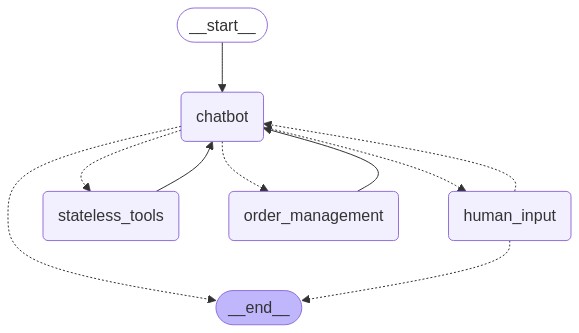

In [13]:
### 13. Graph Definition and Routing
#
# Construct the `StateGraph` by adding nodes and defining the edges (transitions) between them, including conditional routing logic.

graph_builder = StateGraph(CafeGeniusState)

# Add nodes to the graph
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("human_input", human_node)
graph_builder.add_node("stateless_tools", tools_node)
graph_builder.add_node("order_management", order_management_node)

logger.info("Nodes added to graph builder.")

# Define edges and conditional routing logic

# --- Entry Point ---
graph_builder.add_edge(START, "chatbot") # Start with the chatbot (which will send welcome)

# --- Routing from Chatbot ---
def route_from_chatbot(state: CafeGeniusState) -> Literal["stateless_tools", "order_management", "human_input", "__end__"]:
    """Determines the next node after the chatbot generates a response."""
    logger.debug("Executing route_from_chatbot")
    if state.get("finished"):
        logger.debug("Routing from chatbot to END (finished flag is set).")
        return END
    last_message = state['messages'][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Check if any tool call requires the stateful order_management node
        if any(tc['name'] in stateful_tool_names for tc in last_message.tool_calls):
            logger.debug("Routing from chatbot to order_management.")
            return "order_management"
        else:
            # Assume other tool calls are handled by the stateless tools node
            logger.debug("Routing from chatbot to stateless_tools.")
            return "stateless_tools"
    else:
        # No tool calls, or not an AIMessage -> go to human for input
        logger.debug("Routing from chatbot to human_input.")
        return "human_input"

graph_builder.add_conditional_edges(
    "chatbot",
    route_from_chatbot,
    {
        "stateless_tools": "stateless_tools",
        "order_management": "order_management",
        "human_input": "human_input",
        END: END
    }
)

# --- Routing from Human Input ---
def route_from_human(state: CafeGeniusState) -> Literal["chatbot", "__end__"]:
    """Determines the next node after human input."""
    logger.debug("Executing route_from_human")
    if state.get("finished"):
        logger.debug("Routing from human_input to END (finished flag is set).")
        return END
    else:
        # Always go back to the chatbot to process the human input
        logger.debug("Routing from human_input to chatbot.")
        return "chatbot"

graph_builder.add_conditional_edges(
    "human_input",
    route_from_human,
    {
        "chatbot": "chatbot",
        END: END
    }
)

# --- Routing from Tool Nodes ---
# Both stateless and stateful tool nodes always go back to the chatbot
# for it to process the tool results.
graph_builder.add_edge("stateless_tools", "chatbot")
graph_builder.add_edge("order_management", "chatbot")

logger.info("Edges and conditional edges defined.")

# --- Compile the Graph ---
try:
    app = graph_builder.compile()
    logger.info("LangGraph compiled successfully.")

    # Optional: Visualize the graph
    try:
        graph_png = app.get_graph().draw_mermaid_png()
        display(Image(graph_png))
        logger.info("Graph visualization generated.")
    except Exception as viz_error:
        logger.warning(f"Could not generate graph visualization: {viz_error}")

except Exception as compile_error:
    logger.exception("Failed to compile LangGraph.")
    print(f"ERROR: Failed to compile graph: {compile_error}")
    app = None # Ensure app is None if compilation fails

In [14]:
# --- Function to Print Welcome Banner ---
def print_welcome_banner(model_name: str):
    """Prints the detailed welcome banner."""
    banner_lines = [
        f"--> CafeGenius Assistant initializing with model: {model_name}",
        "╔════════════════════════════════════════════════════════════════════════════════╗",
        "║        ⭐ Welcome to CafeGenius Assistant v1.2 (LangGraph Edition)! ⭐         ║", 
        "║            (Capstone Project: Kaggle x Google GenAI Intensive 2025)            ║",
        "║                (Developer: Erwin R. Pasia | erwinpasia@gmail.com)              ║",
        "║                                                                                ║",
        "║  Hi there! I'm your virtual barista, ready to help.                            ║",
        "║  You can ask me about the menu, get recommendations, or manage your order.     ║",
        "║                                                                                ║",
        "║                                                                                ║",
        "║  How can I brighten your day?                                                  ║",
        "╚════════════════════════════════════════════════════════════════════════════════╝"
    ]
    print("\n".join(banner_lines))
    print("-" * (len(banner_lines[1]))) # Separator line matching box width

logger.info("Welcome banner function defined.")


### Section 14 (Running the CafeGenius Agent):
- This final section provides the interactive runtime environment for the agent. It initializes the agent's state, displays a welcome banner, and enters a while loop that repeatedly calls app.invoke(current_state) to execute the compiled LangGraph graph. The loop updates the state based on the graph's output after each turn (which includes running the LLM, tools, and prompting the user via the human_node), continuing until the state's finished flag becomes true (e.g., after placing an order) or the user exits.

In [ ]:
### 14. Running the CafeGenius Agent
#
# This cell initiates the chat loop. It uses `app.invoke` within a loop to manage the conversation turn-by-turn, similar to the structure in the LangGraph example notebook. 
# State is manually passed between invocations.
#
# **Note:** Unlike the original notebook's `chat_with_cafe_genius` function which contained the entire loop logic, here the loop *orchestrates* calls to the compiled LangGraph `app`. 
# The graph itself handles the internal transitions between chatbot, tools, and human input prompts *within* a single `invoke` call until it requires the next external input.

if app and GOOGLE_API_KEY:
    logger.info("Starting interactive chat session...")

    # Print the detailed welcome banner ONCE before the loop
    print_welcome_banner(model_name) # Pass the actual model name variable used
    # ---------------------
    
    # Initial state for the conversation
    current_state = CafeGeniusState(messages=[], current_order=[], finished=False)

    # Configuration for invoke
    config = {"recursion_limit": 150} # Increase recursion depth for complex interactions

    while not current_state.get("finished", False):
        try:
            # Invoke the graph with the current state
            # The graph will run until it hits the 'human_input' node or the END node.
            result_state = app.invoke(current_state, config=config)

            # Update the current state with the result from the graph execution
            # This includes new messages, potentially updated order, and finished status
            current_state = result_state

            # Check finished flag again after invocation (e.g., if place_order was called)
            if current_state.get("finished", False):
                 logger.info("Chat loop ending because 'finished' flag is true in state.")
                 if current_state.get('current_order'):
                      print("\nFinal Order Summary:")
                      final_order_text = ""
                      total = sum(item.get("price", 0.0) * item.get("quantity", 1) for item in current_state['current_order'])
                      for item in current_state['current_order']:
                          mods = f" ({', '.join(item.get('modifiers',[]))})" if item.get('modifiers') else ""
                          final_order_text += f"- {item['quantity']}x {item['name']}{mods}: ${item['price']*item['quantity']:.2f}\n"
                      final_order_text += f"\n**Total: ${total:.2f}**"
                      display(Markdown(final_order_text))
                 else:
                      print("\nNo final order.")
                 break # Exit the while loop

        except KeyboardInterrupt:
            print("\nCafeGenius: Exiting chat session.")
            logger.info("Chat session interrupted by user (KeyboardInterrupt).")
            break
        except Exception as e:
            logger.exception(f"An error occurred during the chat loop invocation: {e}")
            print(f"\n🚨 CafeGenius: Oops! Something went wrong: {str(e)}. Please try again or type 'exit'.")
            # Optional: break or attempt to recover state
            # For simplicity, we continue, but state might be inconsistent
            # current_state['messages'].append(AIMessage(content=f"Sorry, an error occurred: {e}")) # Inform LLM?

    logger.info("Interactive chat session finished.")

elif not GOOGLE_API_KEY:
    print("Cannot start chat: GOOGLE_API_KEY is missing or invalid.")
    logger.error("Chat session not started due to missing API key.")
elif not app:
    print("Cannot start chat: Graph compilation failed.")
    logger.error("Chat session not started due to graph compilation failure.")

--> CafeGenius Assistant initializing with model: gemini-2.0-flash
╔════════════════════════════════════════════════════════════════════════════════╗
║        ⭐ Welcome to CafeGenius Assistant v1.2 (LangGraph Edition)! ⭐         ║
║            (Capstone Project: Kaggle x Google GenAI Intensive 2025)            ║
║                (Developer: Erwin R. Pasia | erwinpasia@gmail.com)              ║
║                                                                                ║
║  Hi there! I'm your virtual barista, ready to help.                            ║
║  You can ask me about the menu, get recommendations, or manage your order.     ║
║                                                                                ║
║                                                                                ║
║  How can I brighten your day?                                                  ║
╚════════════════════════════════════════════════════════════════════════════════╝
----------------------

I'm ready for your request!

In [16]:
#╔════════════════════════════════════════════════════════════════════════════════╗#
#║  Quick Commands / Or Just Ask Naturally:                                         ║#
#║    'menu'                      -> View our offerings                             ║#
#║    'details Latte'             -> Get info on Latte                              ║#
#║    'recommend warm sweet'      -> Get suggestions for warm and sweet items       ║#
#║    'add 2 Cappuccino Oat Milk' -> Add 2 Cappuccinos with Oat Milk                ║#
#║    'remove 1 Cappuccino'       -> Remove one Cappuccino                          ║#
#║    'show my order'             -> See your current order (ask naturally)         ║#
#║    'clear my order'            -> Start your order fresh                         ║#
#║    'exit' or 'bye'             -> End the session                                ║#
#╚════════════════════════════════════════════════════════════════════════════════╝#